In [ ]:
"""
Copyright © 2025 John M. Miller

Permission is hereby granted, free of charge, to any person obtaining a copy
of this Jupyter notebook and associated materials (the “Notebook”), to use,
study, execute, and modify the Notebook for any purpose, subject to the
following conditions:

1. Any redistribution of this Notebook, whether in original or modified form,
   must include an unmodified copy of the original Notebook as distributed by
   the author, clearly identified as the original source.

2. Modified versions may be redistributed only if they are clearly marked as
   modified and accompanied by the complete, unmodified original Notebook.

3. This permission does not grant the right to remove or alter this copyright
   notice.

THE NOTEBOOK IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE, AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHOR BE LIABLE FOR ANY CLAIM, DAMAGES, OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT, OR OTHERWISE, ARISING FROM, OUT OF, OR IN CONNECTION
WITH THE NOTEBOOK OR THE USE OR OTHER DEALINGS IN THE NOTEBOOK.


In [6]:
# ============================================================
# Regression summary (excluding LaterDefLeads)
# ============================================================

import json
import numpy as np
import pandas as pd
import path
REPO = Path.cwd()
if REPO.name.lower() == "notebooks":
    REPO = REPO.parent

IN_JSON = REPO / "data" / "edgar_concise_sanitized.json"

# ----------------------------
# Load sanitized JSON
# ----------------------------
with open(IN_JSON) as f:
    data = json.load(f)

# Sign convention:
# True  -> points accrue when miss < baseline
# False -> points accrue when miss > baseline
BETTER_THAN_BASELINE = True

# ----------------------------
# Helper functions
# ----------------------------
def r2(y, yhat):
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    ybar = y.mean()
    sst = np.sum((y - ybar)**2)
    sse = np.sum((y - yhat)**2)
    return np.nan if sst == 0 else 1.0 - sse/sst

def slope_through_origin(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    denom = x @ x
    return np.nan if denom <= 0 else (x @ y) / denom

def x_raw(t, m, p, better=True):
    if better:
        return t * (p - m)
    else:
        return t * (m - p)

def x_hinge(t, m, p, better=True):
    return np.maximum(0.0, x_raw(t, m, p, better))

def expert_report_constant(expert_arr):
    vals = np.unique(np.round(np.asarray(expert_arr, float), 10))
    if len(vals) == 1:
        return float(vals[0])
    # fallback (should not happen for these detectors)
    return (float(expert_arr.min()), float(expert_arr.max()))

def fit_p_raw_linear(t, m, y, p_min, p_max, grid=20001, better=True):
    """
    Choose p to maximize R^2 for y ≈ k * x_raw
    """
    y = np.asarray(y, float)
    best = None
    for p in np.linspace(float(p_min), float(p_max), int(grid)):
        x = x_raw(t, m, p, better)
        if np.allclose(x, 0.0):
            continue
        k = slope_through_origin(x, y)
        yhat = k * x
        sse = np.sum((y - yhat)**2)
        R = r2(y, yhat)
        cand = dict(p=float(p), k=float(k), R2=float(R), SSE=float(sse))
        if (best is None) or (cand["SSE"] < best["SSE"]):
            best = cand
    if best is None:
        raise RuntimeError("No usable p found in grid.")
    return best

def compute_r2s(t, m, y, p_fit, better=True):
    t = np.asarray(t, float)
    m = np.asarray(m, float)
    y = np.asarray(y, float)

    # Raw linear
    xr = x_raw(t, m, p_fit, better)
    k_raw = slope_through_origin(xr, y)
    R_raw = r2(y, k_raw * xr)

    # Zeros removed
    mask = y > 0
    if np.sum(mask) >= 3:
        xr_f = xr[mask]
        y_f  = y[mask]
        k_f  = slope_through_origin(xr_f, y_f)
        R_f  = r2(y_f, k_f * xr_f)
    else:
        R_f = np.nan

    # Hinge
    xh = x_hinge(t, m, p_fit, better)
    if np.allclose(xh, 0.0):
        R_h = np.nan
    else:
        k_h = slope_through_origin(xh, y)
        R_h = r2(y, k_h * xh)

    return float(R_raw), float(R_f), float(R_h)

# ----------------------------
# Detectors to include
# ----------------------------
DETECTORS = [
    ("individual",  "KOM NT"),
    ("individual",  "KOM Suits"),
    ("individual",  "Weird Ols"),
    ("partnership", "Bad Landings"),
    ("partnership", "Passed Force"),
    ("partnership", "Bad 6m"),
    ("partnership", "RKC 5M"),
]

P_RANGES = {
    ("individual",  "KOM NT"):        (0.0, 0.80),
    ("individual",  "KOM Suits"):     (0.0, 0.80),
    ("individual",  "Weird Ols"):     (0.0, 0.90),
    ("partnership", "Bad Landings"):  (0.0, 0.20),
    ("partnership", "Passed Force"):  (0.0, 1.00),
    ("partnership", "Bad 6m"):        (0.0, 0.40),
    ("partnership", "RKC 5M"):        (0.0, 0.40),
}

# ----------------------------
# Run regressions
# ----------------------------
rows = []

for section, det in DETECTORS:
    rows_data = data[section][det]

    t = [r["tests"] for r in rows_data]
    m = [r["miss_pct"] for r in rows_data]
    e = [r["expert_miss_pct"] for r in rows_data]
    y = [r["points"] for r in rows_data]

    reported_p = expert_report_constant(e)

    pmin, pmax = P_RANGES[(section, det)]
    fit = fit_p_raw_linear(t, m, y, pmin, pmax, grid=20001, better=BETTER_THAN_BASELINE)
    p_fit = fit["p"]

    R_raw, R_filt, R_hinge = compute_r2s(t, m, y, p_fit, better=BETTER_THAN_BASELINE)

    rows.append(dict(
        Detector=det,
        **{
            "Reported p": reported_p,
            "Fitted p": p_fit,
            "R^2 raw": R_raw,
            "R^2 zeros removed": R_filt,
            "R^2 hinge": R_hinge,
        }
    ))

# ----------------------------
# Final table (numeric)
# ----------------------------
tbl = pd.DataFrame(rows).sort_values("R^2 raw", ascending=False)
tbl


,Detector,Reported p,Fitted p,R^2 raw,R^2 zeros removed,R^2 hinge
2,Weird Ols,0.439,0.32445,0.999983,0.999983,0.999983
0,KOM NT,0.400,0.35560,0.999502,0.999715,0.999747
1,KOM Suits,0.400,0.35344,0.999475,0.999798,0.999824
3,Bad Landings,0.045,0.03950,0.998643,0.999839,0.999852
6,RKC 5M,0.150,0.17040,0.968099,NaN,0.981600
5,Bad 6m,0.100,0.16548,0.963229,0.961912,0.970053
4,Passed Force,0.500,0.45150,0.928164,0.947696,0.972775


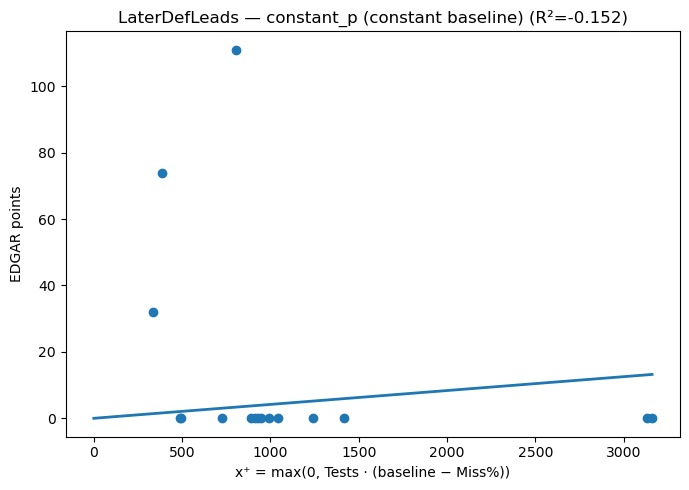

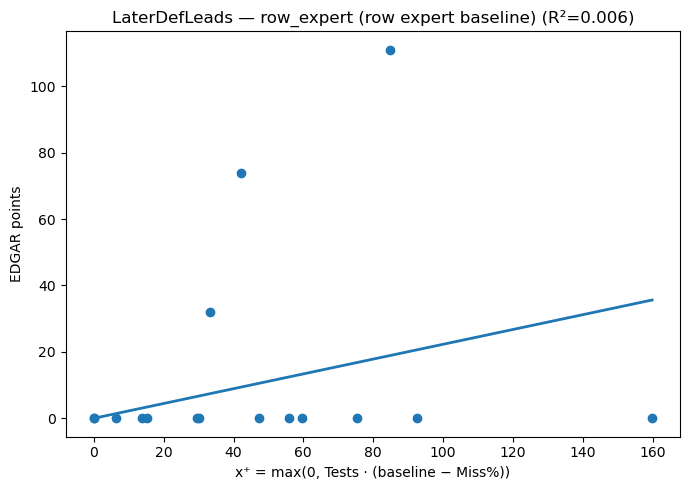

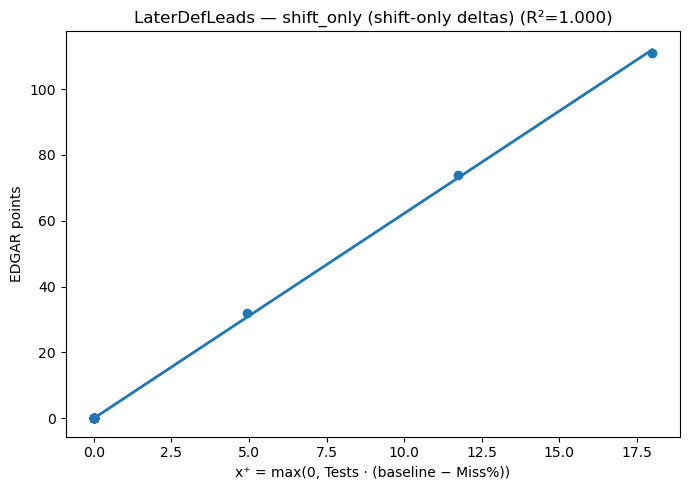

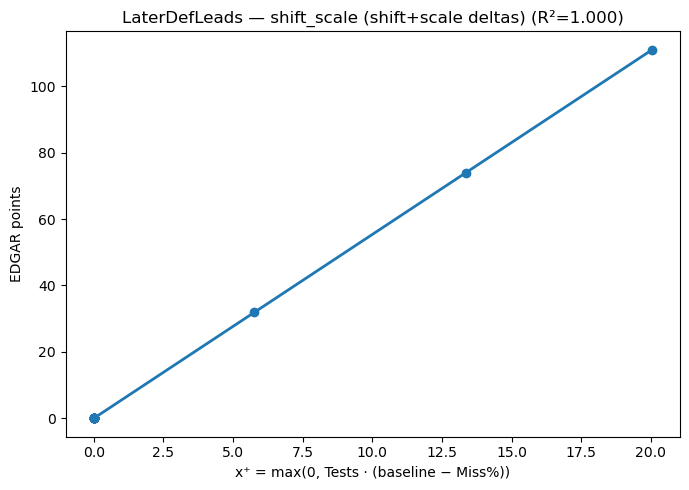

,id,tests,miss,expert,p_model,xplus,points,points_hat
0,player_01,14802.0,0.0882,0.099,0.083363,0.000000,0.0,0.000000
1,player_02,14682.0,0.0847,0.091,0.075647,0.000000,0.0,0.000000
2,player_03,4667.0,0.1043,0.099,0.083363,0.000000,0.0,0.000000
3,player_04,4813.0,0.1028,0.096,0.080470,0.000000,0.0,0.000000
4,player_05,2371.0,0.0936,0.100,0.084328,0.000000,0.0,0.000000
5,player_06,2444.0,0.0974,0.100,0.084328,0.000000,0.0,0.000000
6,player_07,6488.0,0.0818,0.091,0.075647,0.000000,0.0,0.000000
7,player_08,6303.0,0.1033,0.108,0.092044,0.000000,0.0,0.000000
8,player_09,5021.0,0.1020,0.117,0.100724,0.000000,0.0,0.000000
9,player_10,4882.0,0.1172,0.120,0.103618,0.000000,0.0,0.000000


In [2]:
# ============================================================
# LaterDefLeads: shift / shift+scale baseline models
# Fits EDGAR points with a hinge-linear rule using ONLY sanitized JSON
#
# Models:
#   (A) constant baseline p (1D grid)                       p_j = p
#   (B) row-specific baseline equal to reported expert      p_j = e_j
#   (C) shift-only preserves deltas exactly                 p_j = lam + (e_j - mean(e))
#   (D) shift+scale preserves delta pattern up to scale     p_j = lam + eta*(e_j - mean(e))
#
# Score regressor:
#   x_j = tests_j * (p_j - miss_j)      (or miss_j - p_j if BETTER_THAN_BASELINE=False)
#   xplus_j = max(0, x_j)
#   points_j ≈ k * xplus_j             (k via least squares through origin)
#
# Outputs:
#   - best-fit params (p or lam/eta) + k
#   - R^2, SSE, n, n_pos (points>0), n_xpos (xplus>0)
#   - publication-grade plots
# ============================================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import path
REPO = Path.cwd()
if REPO.name.lower() == "notebooks":
    REPO = REPO.parent

IN_JSON = REPO / "data" / "edgar_concise_sanitized.json"

# ------------------------
# Load sanitized JSON
# ------------------------
with open(IN_JSON) as f:
    data = json.load(f)

SECTION  = "individual"
DETECTOR = "LaterDefLeads"

# If True: points accrue when miss is BELOW baseline (p - miss)
# If False: points accrue when miss is ABOVE baseline (miss - p)
BETTER_THAN_BASELINE = True

# Probability safety margin (avoid exact 0/1)
EPS = 1e-9


# ------------------------
# Helpers
# ------------------------
def r2(y, yhat):
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    ybar = y.mean()
    sst = np.sum((y - ybar)**2)
    sse = np.sum((y - yhat)**2)
    return (np.nan if sst == 0 else 1.0 - sse/sst), sse, sst

def slope_through_origin(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    denom = x @ x
    if denom <= 0:
        return np.nan
    return (x @ y) / denom

def hinge_x(tests, miss, p_row, better=True):
    # p_row may be scalar or vector
    if better:
        x = tests * (p_row - miss)
    else:
        x = tests * (miss - p_row)
    return np.maximum(0.0, x)

def within_unit_interval(p_row, eps=EPS):
    p_row = np.asarray(p_row, float)
    return np.all((p_row >= eps) & (p_row <= 1.0 - eps))

def extract_laterdefleads_arrays(data):
    rows = data[SECTION][DETECTOR]
    t = np.array([r["tests"] for r in rows], float)
    m = np.array([r["miss_pct"] for r in rows], float)
    e = np.array([r["expert_miss_pct"] for r in rows], float)
    y = np.array([r["points"] for r in rows], float)
    ids = [r["id"] for r in rows]
    return ids, t, m, e, y


# ------------------------
# Fit routines
# ------------------------
def fit_constant_p(t, m, y, p_min=0.0, p_max=0.4, grid=20001, better=True):
    best = None
    for p in np.linspace(float(p_min), float(p_max), int(grid)):
        p_row = p
        xplus = hinge_x(t, m, p_row, better=better)
        if np.allclose(xplus, 0.0):
            continue
        k = slope_through_origin(xplus, y)
        yhat = k * xplus
        R2, sse, _ = r2(y, yhat)
        cand = dict(model="constant_p", p=p, k=k, R2=R2, SSE=sse,
                    n=len(y), n_pos=int(np.sum(y > 0)), n_xpos=int(np.sum(xplus > 0)))
        if (best is None) or (cand["SSE"] < best["SSE"]):
            best = cand
    return best

def fit_row_expert(t, m, e, y, better=True):
    # p_row = e_j (as given)
    if not within_unit_interval(e):
        raise ValueError("Expert miss% has values outside (0,1); check pct normalization.")
    xplus = hinge_x(t, m, e, better=better)
    if np.allclose(xplus, 0.0):
        raise ValueError("xplus is identically 0 under p_row=e; check sign convention.")
    k = slope_through_origin(xplus, y)
    yhat = k * xplus
    R2, sse, _ = r2(y, yhat)
    return dict(model="row_expert", k=k, R2=R2, SSE=sse,
                n=len(y), n_pos=int(np.sum(y > 0)), n_xpos=int(np.sum(xplus > 0)))

def fit_shift_only(t, m, e, y, lam_min=0.0, lam_max=0.4, grid=20001, better=True):
    # p_j = lam + (e_j - mean(e))  (deltas preserved exactly)
    de = e - e.mean()
    best = None
    for lam in np.linspace(float(lam_min), float(lam_max), int(grid)):
        p_row = lam + de
        if not within_unit_interval(p_row):
            continue
        xplus = hinge_x(t, m, p_row, better=better)
        if np.allclose(xplus, 0.0):
            continue
        k = slope_through_origin(xplus, y)
        yhat = k * xplus
        R2, sse, _ = r2(y, yhat)
        cand = dict(model="shift_only", lam=lam, eta=1.0, k=k, R2=R2, SSE=sse,
                    n=len(y), n_pos=int(np.sum(y > 0)), n_xpos=int(np.sum(xplus > 0)))
        if (best is None) or (cand["SSE"] < best["SSE"]):
            best = cand
    return best

def fit_shift_scale(t, m, e, y,
                    lam_range=(0.0, 0.4), eta_range=(0.0, 3.0),
                    lam_grid=2001, eta_grid=2001,
                    better=True):
    """
    2D grid search:
        p_j = lam + eta*(e_j - mean(e))
    Discards any (lam,eta) that push any p_j outside (0,1).
    """
    de = e - e.mean()
    lam_min, lam_max = map(float, lam_range)
    eta_min, eta_max = map(float, eta_range)

    lam_vals = np.linspace(lam_min, lam_max, int(lam_grid))
    eta_vals = np.linspace(eta_min, eta_max, int(eta_grid))

    best = None

    # Vectorized over lam for each eta (fast enough for these n~16)
    for eta in eta_vals:
        p_mat = lam_vals[:, None] + eta * de[None, :]
        ok = np.all((p_mat >= EPS) & (p_mat <= 1.0 - EPS), axis=1)
        if not np.any(ok):
            continue

        for lam in lam_vals[ok]:
            p_row = lam + eta * de
            xplus = hinge_x(t, m, p_row, better=better)
            if np.allclose(xplus, 0.0):
                continue
            k = slope_through_origin(xplus, y)
            yhat = k * xplus
            R2, sse, _ = r2(y, yhat)
            cand = dict(model="shift_scale", lam=float(lam), eta=float(eta), k=float(k),
                        R2=float(R2), SSE=float(sse),
                        n=len(y), n_pos=int(np.sum(y > 0)), n_xpos=int(np.sum(xplus > 0)))
            if (best is None) or (cand["SSE"] < best["SSE"]):
                best = cand

    return best


# ------------------------
# Run LaterDefLeads analysis
# ------------------------
ids, t, m, e, y = extract_laterdefleads_arrays(data)

# (A) constant p hinge: keep range modest; LaterDefLeads expert ~0.09-0.12
best_const = fit_constant_p(t, m, y, p_min=0.0, p_max=0.3, grid=20001, better=BETTER_THAN_BASELINE)

# (B) row-specific expert p_j = e_j
best_expert = fit_row_expert(t, m, e, y, better=BETTER_THAN_BASELINE)

# (C) shift-only: choose lam range that keeps probabilities valid; use a generous bound
best_shift = fit_shift_only(t, m, e, y, lam_min=0.0, lam_max=0.4, grid=20001, better=BETTER_THAN_BASELINE)

# (D) shift+scale: coarser grid first; refine later if desired
best_shiftscale = fit_shift_scale(
    t, m, e, y,
    lam_range=(0.0, 0.4),
    eta_range=(0.0, 3.0),
    lam_grid=2001,
    eta_grid=2001,
    better=BETTER_THAN_BASELINE
)

summary = pd.DataFrame([
    {**best_const},
    {**best_expert},
    {**best_shift},
    {**best_shiftscale},
]).sort_values(["model"])

summary


# ------------------------
# Build regressors for plotting for each model
# ------------------------
def p_row_from_model(model_dict, e):
    if model_dict["model"] == "constant_p":
        return np.full_like(e, model_dict["p"], dtype=float)
    if model_dict["model"] == "row_expert":
        return e.astype(float)
    if model_dict["model"] == "shift_only":
        de = e - e.mean()
        return float(model_dict["lam"]) + de
    if model_dict["model"] == "shift_scale":
        de = e - e.mean()
        return float(model_dict["lam"]) + float(model_dict["eta"]) * de
    raise ValueError("Unknown model")

def plot_points_vs_regressor(model_dict, t, m, e, y, better=True, title_extra=""):
    p_row = p_row_from_model(model_dict, e)
    xplus = hinge_x(t, m, p_row, better=better)
    k = model_dict["k"]
    yhat = k * xplus
    R2, _, _ = r2(y, yhat)

    plt.figure(figsize=(7,5))
    plt.scatter(xplus, y)
    xx = np.linspace(0.0, max(1e-12, xplus.max()), 200)
    plt.plot(xx, k*xx, linewidth=2)
    plt.xlabel("x⁺ = max(0, Tests · (baseline − Miss%))")
    plt.ylabel("EDGAR points")
    plt.title(f"LaterDefLeads — {model_dict['model']}{title_extra} (R²={R2:.3f})")
    plt.tight_layout()
    plt.show()

# Plots: hinge regressor vs points for each model
plot_points_vs_regressor(best_const,      t, m, e, y, better=BETTER_THAN_BASELINE, title_extra=" (constant baseline)")
plot_points_vs_regressor(best_expert,     t, m, e, y, better=BETTER_THAN_BASELINE, title_extra=" (row expert baseline)")
plot_points_vs_regressor(best_shift,      t, m, e, y, better=BETTER_THAN_BASELINE, title_extra=" (shift-only deltas)")
plot_points_vs_regressor(best_shiftscale, t, m, e, y, better=BETTER_THAN_BASELINE, title_extra=" (shift+scale deltas)")


# ------------------------
# Optional: quick diagnostic table (per-row) for best shift+scale
# ------------------------
best = best_shiftscale
p_row = p_row_from_model(best, e)
xplus = hinge_x(t, m, p_row, better=BETTER_THAN_BASELINE)
diag = pd.DataFrame({
    "id": ids,
    "tests": t,
    "miss": m,
    "expert": e,
    "p_model": p_row,
    "xplus": xplus,
    "points": y,
    "points_hat": best["k"] * xplus,
})
diag


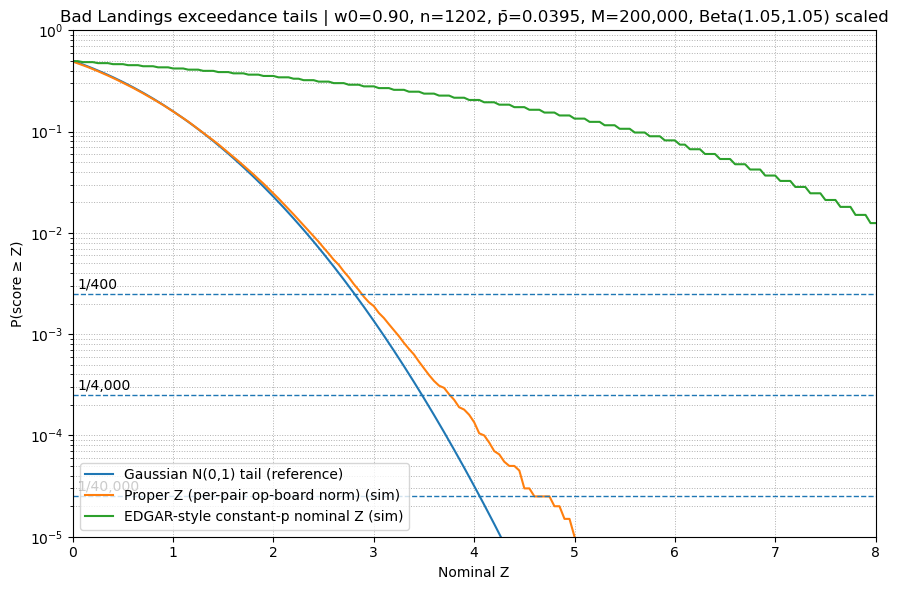

Sanity checks:
  mean(m_op) ≈ 120.23 (expected 120.20)
  mean(p_op_pair) ≈ 0.395751 (target mu_op=0.395000)
  mean(k_miss)/n ≈ 0.039567 (target pbar_all=0.039500)
  Z_edgar: mean= 0.011934, std= 4.110971
  Z_true : mean=-0.004619, std= 1.000173


In [13]:
# Bad Landings exceedance-tail plot (the “fat green tail” version)
# Key mechanism: per-PAIR latent miss rate on opportunity boards (mixture across pairs),
# not per-board heterogeneity re-drawn each trial.

import numpy as np
import matplotlib.pyplot as plt
import math

# -----------------------------
# Parameters (edit these)
# -----------------------------
w0        = 0.90      # fraction of boards with NO opportunity
n_tests   = 1202      # in the article range of EDGAR tests is 1202 to 8123
pbar_all  = 0.0395    # overall baseline miss rate across ALL boards (including no-op boards)
M         = 200_000   # Monte Carlo pairs
alpha     = 1.05      # "nearly uniform" Beta slab shape (alpha=beta ~1 is ~uniform)
beta      = 1.05
zmax      = 8.0
dz        = 0.05
seed      = 123

# -----------------------------
# Helpers
# -----------------------------
def gauss_tail(z):
    # P(N(0,1) >= z) = 0.5*erfc(z/sqrt(2))
    # math.erfc is scalar; vectorize safely.
    z = np.asarray(z, dtype=float)
    return 0.5 * np.vectorize(math.erfc)(z / math.sqrt(2.0))

def survival(scores, zgrid):
    # empirical tail P(score >= z)
    scores = np.asarray(scores)
    return np.array([(scores >= z).mean() for z in zgrid], dtype=float)

# -----------------------------
# Simulation: mixture across pairs
# -----------------------------
rng = np.random.default_rng(seed)

# Opportunity-board mean needed so that overall mean equals pbar_all:
# E[miss] = (1-w0) * E[p_op]  => E[p_op] = pbar_all/(1-w0)
mu_op = pbar_all / max(1e-12, (1.0 - w0))

# Draw a latent "slab" probability per pair and scale it to hit mu_op in expectation.
# q ~ Beta(alpha, beta), with mean alpha/(alpha+beta)
q = rng.beta(alpha, beta, size=M)
mean_q = alpha / (alpha + beta)
scale = mu_op / mean_q

p_op_pair = np.clip(scale * q, 0.0, 1.0)  # per-pair miss prob on opportunity boards

# Number of opportunity boards seen by each pair
m_op = rng.binomial(n_tests, 1.0 - w0, size=M)

# Miss counts (no-op boards contribute deterministic 0)
k_miss = rng.binomial(m_op, p_op_pair)

# EDGAR-style "nominal Z" (assumes Binomial(n_tests, pbar_all))
den_edgar = math.sqrt(n_tests * pbar_all * (1.0 - pbar_all))
Z_edgar = (k_miss - n_tests * pbar_all) / den_edgar

# "Proper Z" for the same simulated world:
# conditional on (m_op, p_op_pair), the right normalization is sqrt(m p(1-p)).
# This is the per-pair, per-opportunity Z you’d expect ~N(0,1) (aside from discreteness).
den_true = np.sqrt(np.maximum(1.0, m_op * p_op_pair * (1.0 - p_op_pair)))
Z_true = (k_miss - m_op * p_op_pair) / den_true

# -----------------------------
# Exceedance curves
# -----------------------------
zgrid = np.arange(0.0, zmax + 1e-9, dz)

tail_gauss = gauss_tail(zgrid)
tail_true  = survival(Z_true,  zgrid)
tail_edgar = survival(Z_edgar, zgrid)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(9,6))
plt.semilogy(zgrid, tail_gauss, label="Gaussian N(0,1) tail (reference)")
plt.semilogy(zgrid, tail_true,  label="Proper Z (per-pair op-board norm) (sim)")
plt.semilogy(zgrid, tail_edgar, label="EDGAR-style constant-p nominal Z (sim)")

# Horizontal reference lines
for y, lab in [(1/400, "1/400"), (1/4000, "1/4,000"), (1/40000, "1/40,000")]:
    plt.axhline(y, linestyle="--", linewidth=1)
    plt.text(0.05, y*1.05, lab, fontsize=10, va="bottom")

plt.ylim(1e-5, 1)
plt.xlim(0, zmax)
plt.grid(True, which="both", linestyle=":", linewidth=0.7)
plt.xlabel("Nominal Z")
plt.ylabel("P(score ≥ Z)")
plt.title(f"Bad Landings exceedance tails | w0={w0:.2f}, n={n_tests}, p̄={pbar_all:.4f}, M={M:,}, Beta({alpha},{beta}) scaled")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# -----------------------------
# Sanity checks
# -----------------------------
print("Sanity checks:")
print(f"  mean(m_op) ≈ {m_op.mean():.2f} (expected {(1-w0)*n_tests:.2f})")
print(f"  mean(p_op_pair) ≈ {p_op_pair.mean():.6f} (target mu_op={mu_op:.6f})")
print(f"  mean(k_miss)/n ≈ {k_miss.mean()/n_tests:.6f} (target pbar_all={pbar_all:.6f})")
print(f"  Z_edgar: mean={Z_edgar.mean(): .6f}, std={Z_edgar.std(ddof=0): .6f}")
print(f"  Z_true : mean={Z_true.mean(): .6f}, std={Z_true.std(ddof=0): .6f}")

# Tip: change n_tests to 8123 and re-run.
# In this mixture model, the EDGAR-style tail typically gets more inflated as n increases.
